# 1. Introduction
Today I'll share with you how to build a [dumbbell chart](https://datavizproject.com/data-type/dumbbell-plot/#) by using *Matplotlib*. 

As [Tableau Playbook - Dumbbell Chart](https://www.pluralsight.com/guides/tableau-playbook-dumbbell-chart) tells:

> A dumbbell chart is a composite chart with **circles** and **lines**. It is ideal for **illustrating change** and **comparing the distance** between **two groups of data points**. The dumbbell chart has many aliases, such as DNA chart, gap chart, barbell chart, and connected dot plot.
>
> Like a lollipop chart, the dumbbell chart is used to **compare categorical data**. It uses circles to **highlight values** and bars to **measure the gap**.
>
> On the other hand, the end circle **overstates** the value and **blurs the boundary**. Moreover, the **lack of baseline** makes **precise comparison** more difficult.

From the concept and characteristics described above, a dumbbell chart is mainly used to compare the difference between two groups of categorical data points, where circles' position represents the absolute values in each group, and the bars or lines connecting the two circles to measure the gap by their length.

This example comes from the challenge [**#WOW2022 Week 32: Can you build a dumbbell chart?**](https://workout-wednesday.com/2022w32tab/). The original challege used *Tableau* as the visualization tool. In this practice, I try to re-produce by *Matplotlib* the dumbbell chart as same as possible with the *Tableau* counterpart. Without further ado, let's do it!

# 2. How to build it

First, we need to import some necessary libraries, such as `numpy`, `pandas`, `matplotlib`, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Additional imports
import matplotlib.collections as mcol
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.offsetbox as moffsetbox
import re

Then, we need to load the data from [Teen-Tween_Smartphone_Ownership.xlsx](https://github.com/chenyulue/hands-on-datavis/raw/master/datasets/Teen-Tween_Smartphone_Ownership.xlsx).

In [2]:
data_file = '../../datasets/Teen-Tween_Smartphone_Ownership.xlsx'
phone_ownership = pd.read_excel(data_file)
phone_ownership.head()

,Year,Age,Ownership
0,2015,8,0.11
1,2015,9,0.15
2,2015,10,0.19
3,2015,11,0.32
4,2015,12,0.41


To create the dumbbell chart, we need to build two groups of points for years 2015 and 2019, which can be achieved by using `Axes.scatter` method for data of each year. Afterwards we build the connecting lines between points of years 2015 and 2019 for each age group with `collections.LineCollection`.

Besides, we need to highlight some text in the figure description. The default `Axes.text` and `Axes.annotate` don't support partially highlighting. To achieve this, we can use `offsetbox.TextArea`, `offsetbox.HPacker`, `offsetbox.VPacker` and `offsetbox.AnnotationBbox`. `offsetbox.TextArea` can customize the font property for the selected text, then we use `offsetbox.HPacker` and `offset.VPacker` to align the multiple customized text, and finally `offsetbox.AnnotationBbox` packs all the text boxes and place them in the specific position.

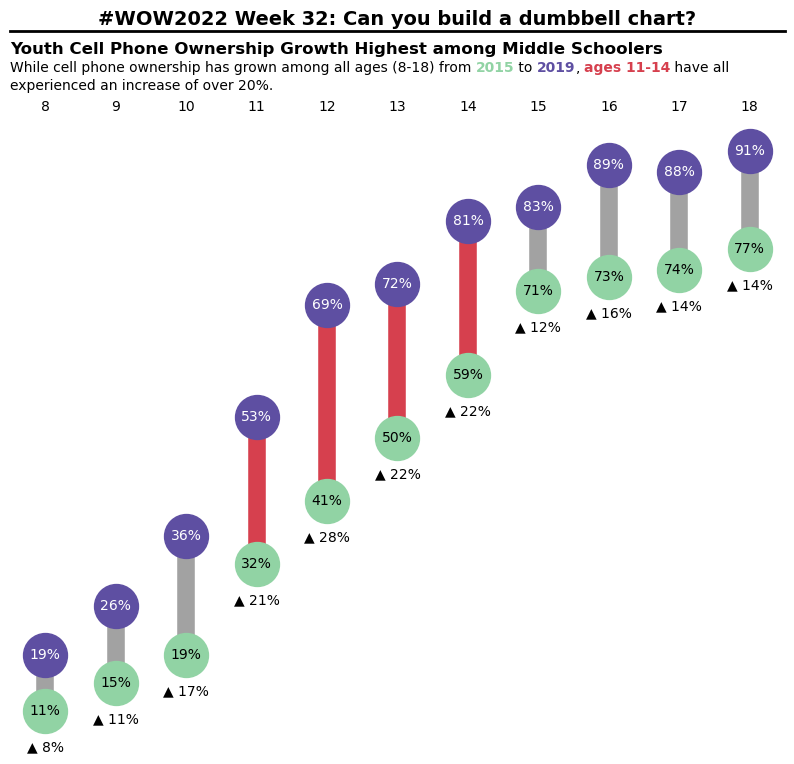

In [3]:
# Create a figure of size 1000 * 800 pixels. 
px = 1 / plt.rcParams['figure.dpi']
fig, ax = plt.subplots(figsize=(1000*px, 800*px))

# Some initializaton
color_for_years = ['#91D3A4', '#5E4FA2']
color_for_labels = ['black', 'white']
years = [2015, 2019]
circle_size = 1000

# Draw two groups of scatter points for each age group in years 2015 and 2019
dots = []   # For collecting coordinates of points in years 2015 and 2019
for year, year_color, label_color in zip(years, color_for_years, color_for_labels):
    selected = phone_ownership[phone_ownership['Year'] == year]
    ax.scatter(selected['Age'], selected['Ownership'],
               c=year_color, s=circle_size)

    # Add the label of the percentage form
    for _, age, pct in selected.itertuples(index=False):
        ax.text(age, pct, f'{pct*100:.0f}%', ha='center', va='center',
                c=label_color)
        
    # Collect the point coordinates
    dots.append(selected.loc[:, ['Age', 'Ownership']].values)

# Use the `LineCollection` to add the collecting lines for performance.
line_colors = ['#a2a2a2'] * 3 + ['#d6404e'] * 4 + ['#a2a2a2'] * 4
connecting_lines = mcol.LineCollection(zip(*dots), lw=np.sqrt(circle_size)/2.5, 
                                       zorder=0, # So that connecting line placed beneath the scatter points
                                       edgecolors=line_colors)
ax.add_collection(connecting_lines)

# Customize the spines and axises
ax.tick_params(bottom=False, left=False, 
               labelbottom=False, labelleft=False, labeltop=True)
ax.set_xticks(dots[1][:,0])
ax.spines[:].set_visible(False)

# Add circle labels
for data2015, data2019 in zip(*dots):
    diff = data2019[1] - data2015[1]
    ax.annotate(f"▲ {diff*100:.0f}%", xy=data2015, xytext=(0, -np.sqrt(circle_size)/2-5), 
                textcoords="offset points", ha='center', va='top')

################### Function Definition #############################
# Define a partially highlighting function
def highlight_annotate(ax, des, sep=3, *args, **kwargs):
    """
    ax: Axes
    des: description, highlighting part of the form <hl property=value, ...>text</hl>

    Return
    ------
    AnnotationBbox
    height in points of the AnnotationBbox
    """
    lines = des.splitlines()
    lines_area = []
    lines_fontsize = []
    for line in lines:
        text_area = []
        line_heights = []
        for text in re.split('(?=<)', line):
            if text.startswith('</hl>'):
                text_area.append(moffsetbox.TextArea(text[len("</hl>"):]))
            elif text.startswith('<hl'):
                prop, txt = text.split('>')
                text_props = {}
                for k, v in re.findall(r"(\w+)\s*=\s*([^=\s]+)", prop):
                # Font properties only inludes int, float or string values
                    try:
                        text_props[k] = int(v)
                        if k == 'fontsize':
                            line_heights.append(int(v))     # Collect fontsizes for each highlighted text
                    except ValueError:
                        try:
                            text_props[k] = float(v)
                        except ValueError:
                            text_props[k] = v[1:-1]
                text_area.append(moffsetbox.TextArea(txt, textprops=text_props))
            else:
                text_area.append(moffsetbox.TextArea(text))
        # Get the max fontsize for each line, if empty then the default 10 points.
        lines_fontsize.append(max(line_heights) if line_heights else 10)
        if len(text_area) > 1:
            lines_area.append(moffsetbox.HPacker(children=text_area, pad=0, sep=0))
        else:
            lines_area.append(text_area[0])

    lines_box = moffsetbox.VPacker(children=lines_area, pad=0, sep=sep)
    ann_box = moffsetbox.AnnotationBbox(lines_box, *args, **kwargs)
    ax.add_artist(ann_box)
    return ann_box, sum(lines_fontsize) + len(lines_fontsize) * sep
################### Function End ######################################                

# Calculate the offset in points of the top of the x-axis ticklabels
pad = (ax.xaxis.get_tick_padding() +    # Tick length in points
       ax.xaxis.get_major_ticks()[0].get_pad() +    # Distance in points between the ticklabel and the tick
       1.5 * ax.xaxis.get_majorticklabels()[0].get_fontsize() # Font size of tick labels
)
# Highlight the figure description
des = f"While cell phone ownership has grown among all ages (8-18) from \
<hl color='{color_for_years[0]}' fontweight='bold'>2015</hl> to \
<hl color='{color_for_years[1]}' fontweight='bold'>2019</hl>, \
<hl color='#d6404e' fontweight='bold'>ages 11-14</hl> have \
all \nexperienced an increase of over 20%."
_, des_pad = highlight_annotate(ax, des, xy=(0, 1), xybox=(0, pad),
                    xycoords='axes fraction', boxcoords='offset points',
                    box_alignment=(0, 0), pad=0, frameon=False)

# Add the description title
des_title = "Youth Cell Phone Ownership Growth Highest among Middle Schoolers"
des_title_pad = pad + des_pad
des_title_txt = ax.annotate(des_title, xy=(0, 1), xytext=(0, des_title_pad), 
                          xycoords="axes fraction", textcoords="offset points",
                          ha='left', va='bottom', fontsize=12, fontweight='bold')

# Add the seprator line
title_pad = des_title_pad + des_title_txt.get_fontsize() * 1.5
sepline_trans = ax.transAxes + mtransforms.ScaledTranslation(0, title_pad/72, fig.dpi_scale_trans)
sep_line = mlines.Line2D((0, 1), (1, 1), lw=2, c='k', clip_on=False, transform=sepline_trans)
ax.add_artist(sep_line)

# Add the project title
fig_title = "#WOW2022 Week 32: Can you build a dumbbell chart?"
ax.annotate(fig_title, xy=(0.5, 1), xytext=(0, title_pad + 2),
            xycoords="axes fraction", textcoords="offset points",
            ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.show()

# 3. Interactive plot

I almost recreate the Dumbbell Chart only by using `Matplotlib`. I say "almost" because the tooltip has not been achieved. Since `Matplotlib` is primarily used to create static charts, I won't spend times on the tooltip implementation although with the help of *QtAgg* backend or other similar backends the tooltip can be achieved. I'll recreate this chart with `plotly`, which is more useful for interactive plotting.

The routine of building the dumbbell chart by `plotly` is the same as that by `matplotlib`, drawing two groups of scattered points and then connecting them with a line.

In [4]:
# Necessary imports to use plotly
import plotly.express as px

# The dataset
phone_ownership['Year'] = phone_ownership['Year'].astype(str)
phone_ownership.head()

,Year,Age,Ownership
0,2015,8,0.11
1,2015,9,0.15
2,2015,10,0.19
3,2015,11,0.32
4,2015,12,0.41


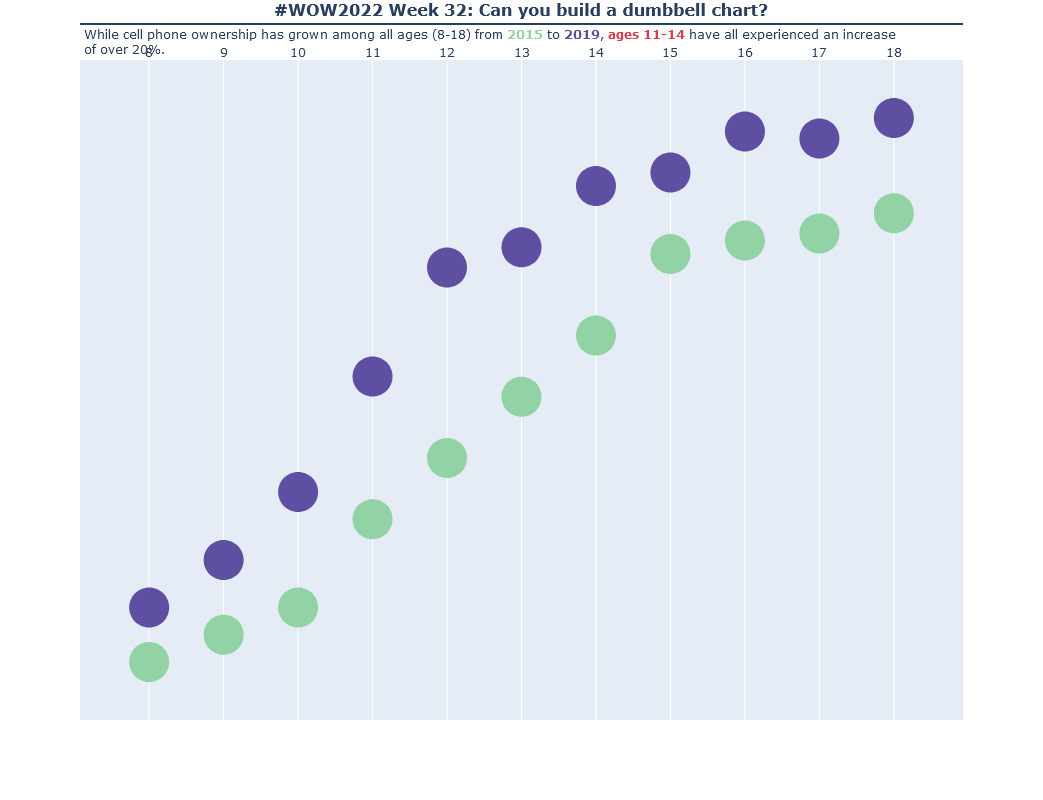

In [41]:
dot_size = 40

fig = px.scatter(phone_ownership, x="Age", y="Ownership", color="Year", 
                 color_discrete_map=dict(zip(['2015','2019'], color_for_years)),
                 width=1000, height=800)

fig.update_traces(
    marker_size=dot_size,
    selector=dict(mode="markers")
)
fig.add_annotation(
    x=0, y=1, xref="x domain", yref="y domain",
    text=("While cell phone ownership has grown among all ages (8-18) " + 
          "from <span style='color:#91D3A4;font-weight:bold'>2015</span> to <span style='color:#5E4FA2;font-weight:bold'>2019</span>, " +
          "<span style='color:#d6404e;font-weight:bold'>ages 11-14</span> have all experienced an increase <br>of over 20%."),
    showarrow=False,
    xanchor="left", yanchor="bottom",
    align="left",
)

top_margin = fig.full_figure_for_development(warn=False).layout.margin.t
bottom_margin = fig.full_figure_for_development(warn=False).layout.margin.b
default_size = fig.full_figure_for_development(warn=False).layout.annotations[0].font.size
y = 1 + default_size * 1.5 * 2 / (fig.layout.height - top_margin - bottom_margin)
fig.add_shape(
    type="line",
    x0=0, y0=y, x1=1, y1=y, xref="x domain", yref="y domain",
    line=dict(width=2),
)

fig.add_annotation(
    x=0.5, y=1, xref="x domain", yref="y domain",
    text="<b>#WOW2022 Week 32: Can you build a dumbbell chart?</b>",
    showarrow=False,
    font=dict(size=16),
    xanchor="center", yanchor="bottom",
    yshift=default_size * 1.5 * 2 + 1,
)

fig.update_layout(
    # plot_bgcolor="white",
    showlegend=False,
)
fig.update_xaxes(
    title_text="",
    tickvals=np.arange(8, 19),
    side="top",
)
fig.update_yaxes(
    visible=False,
)
fig.show()

# print(fig.layout.xaxis.ticklen)